In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seregakaban","key":"e8afd2c8816818b78535042a8fc422a3"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset

fast-food-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('fast-food-classification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# resnet50
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
train_dir ='/content/Fast Food Classification V2/Train'
test_dir = '/content/Fast Food Classification V2/Valid'

In [ ]:
# Augment train set only
train_data_generator = ImageDataGenerator(
                    validation_split=0.15,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function=preprocess_input,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

val_data_generator = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    validation_split=0.15)

In [ ]:
HYP = dict(
    seed = 77,
    batch_size = 32,
    img_size = (256,256),
    epochs = 2,
    patience = 5)

In [ ]:
train_generator = train_data_generator.flow_from_directory(
                train_dir, target_size=HYP['img_size'],
                shuffle=True, seed=HYP['seed'],
                class_mode='categorical',
                batch_size=HYP['batch_size'],
                subset="training")

validation_generator = val_data_generator.flow_from_directory(
                    train_dir, target_size=HYP['img_size'],
                    shuffle=False, seed=HYP['seed'],
                    class_mode='categorical',
                    batch_size=HYP['batch_size'],
                    subset="validation")

Found 12750 images belonging to 10 classes.
Found 2250 images belonging to 10 classes.


In [ ]:
# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.001 * (5 - epoch))

lr_scheduler = LearningRateScheduler(scheduler)

# early_stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)

callbacks = [early_stopping, lr_scheduler]

In [ ]:
# Resnet50
model_res50 = Sequential()

model_res50.add(ResNet50(
include_top=False,
pooling='avg',
weights='imagenet'
))

model_res50.add(Dense(1024, activation='relu'))

model_res50.add(Dropout(0.5))

model_res50.add(Dense(10, activation='softmax'))

model_res50.layers[0].trainable = False

model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

model_res50.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 25696138 (98.02 MB)
Trainable params: 2108426 (8.04 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
fit_history = model_res50.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch_training,
            validation_steps=steps_per_epoch_validation,
            epochs=HYP['epochs'],
            validation_data=validation_generator,
            verbose=1,
            callbacks=callbacks
            )

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


399/399 [==============================] - 3939s 10s/step - loss: 0.9608 - accuracy: 0.7017 - val_loss: 0.5638 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 2/2
399/399 [==============================] - 3927s 10s/step - loss: 0.6887 - accuracy: 0.7777 - val_loss: 0.5555 - val_accuracy: 0.8258 - lr: 0.0010


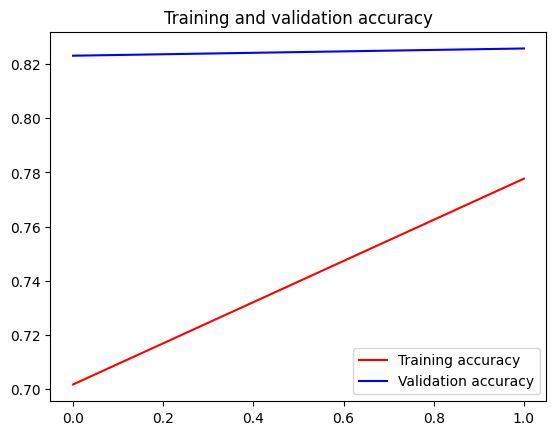

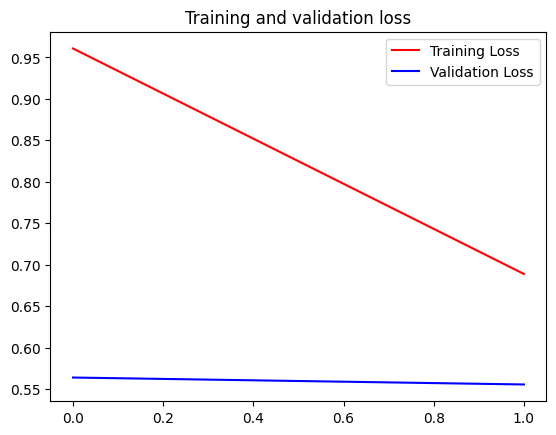

In [ ]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

71/71 [==============================] - 551s 8s/step


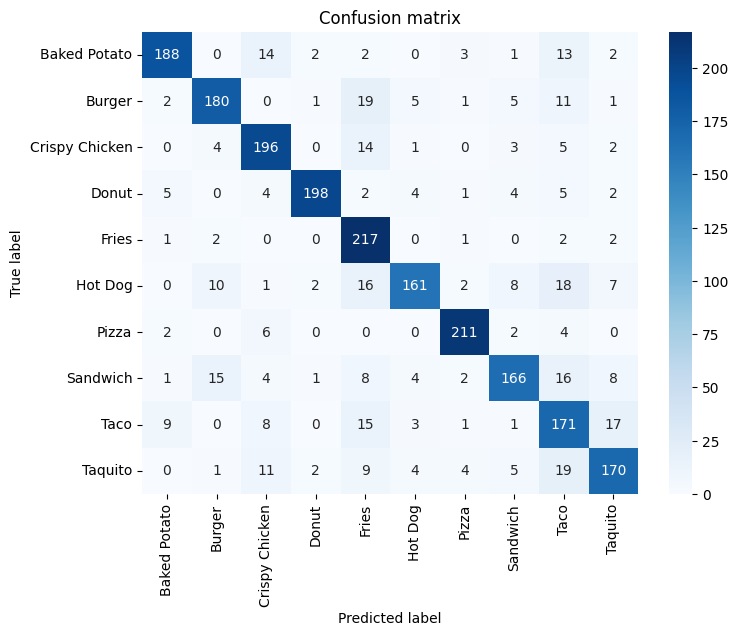

In [ ]:
# Confusion matrix

classes = train_generator.class_indices.keys()

y_pred = np.argmax(model_res50.predict(validation_generator), axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
model_res50.save('project.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_res50.save('project.keras')